# WavLM Based DeepFake Audio Detection

* In this notebook, we are going to use WavLM based classifier which directly operated over raw audio for different tasks.
* Here, we are going to use for deepfake audio detection


## Summary of Key Processing Steps
1. Works directly on raw audio, allowing for easy input preparation.
2. Utilizes convolutional layers for feature extraction followed by a Transformer encoder to capture global context in the audio.
3. Gated Relative Position Bias: Enhances contextual understanding, which is especially useful in capturing anomalies or artifacts typical in deepfake audio.
4. Fine-tuning for classification is achieved by adding a simple classification head and pooling mechanism to convert the sequence of features into a single prediction.
5. This process enables WavLM to excel in deepfake detection tasks by capturing nuanced patterns that distinguish real from synthetic audio, leveraging both local and global information in the audio signal.

In [4]:
# Standard library imports
import os  # OS operations
import random  # Random operations
from tqdm import tqdm  # Progress bar for loops

# PyTorch imports
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network layers
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, Dataset  # Data utilities
from torch.optim.lr_scheduler import CosineAnnealingLR  # Learning rate scheduler

# Audio processing and NLP model imports
import torchaudio  # Audio loading and transformations
from transformers import Wav2Vec2FeatureExtractor

# Data analysis and visualization imports
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Plotting library
from torch.utils.tensorboard import SummaryWriter  # Logging for TensorBoard visualization
from IPython.display import Audio # For plotting audio
# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Classification metrics


## Data Visualization

> In the realm of deepfake audio detection, various audio features are instrumental in distinguishing between authentic and synthetic recordings. Among these, spectrograms, Mel spectrograms, and chroma features are particularly noteworthy.

### Spectograms
* Spectrograms provide a visual representation of an audio signal's frequency spectrum over time, capturing both temporal and spectral information. This dual representation is advantageous for detecting anomalies indicative of deepfake audio. For instance, certain synthesis methods may introduce artifacts or inconsistencies in the frequency domain, which become apparent when analyzing spectrograms. By examining these visual patterns, researchers can identify irregularities that suggest audio manipulation.
ARXIV

## Mel Spectograms
* Mel spectrograms are a variant of spectrograms that map frequencies onto the Mel scale, aligning more closely with human auditory perception. This perceptually motivated scaling emphasizes frequencies to which the human ear is more sensitive, thereby enhancing the detection of subtle artifacts introduced by deepfake generation techniques. Studies have demonstrated that Mel spectrograms, when used as input features for convolutional neural networks, improve the accuracy of deepfake audio detection systems.
ICTACT JOURNALS

## Chroma Features
* Chroma features capture the energy distribution across the twelve distinct pitch classes of the musical octave, effectively summarizing harmonic content. In the context of deepfake detection, chroma features are valuable for identifying inconsistencies in the harmonic structure of audio signals. Synthetic audio may exhibit unnatural harmonic patterns or deviations in pitch class distributions, which chroma analysis can reveal. Incorporating chroma features into detection frameworks has been shown to enhance the robustness of classifiers against various types of audio forgeries.
IEEE XPLORE

> Collectively, these features—spectrograms, Mel spectrograms, and chroma features—serve as critical tools in the detection of deepfake audio. By providing comprehensive insights into the spectral, perceptual, and harmonic characteristics of audio signals, they enable more effective identification of synthetic content.

In [5]:
# Function for data visualization

def visualize_audio_features(audio_file):
    """
    Visualizes different audio representations: waveform, spectrogram, Mel spectrogram, and chroma feature.

    Args:
        audio_file (str): Path to a specific audio file (.flac or any other format supported by torchaudio).
    """
    # Load the audio file
    audio, sample_rate = torchaudio.load(audio_file)

    # Ensure audio is in mono for consistent visualization
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0)

    # Normalize audio for better visualization
    audio = audio / torch.max(torch.abs(audio))
    waveform_audio = audio.squeeze().numpy()

    # Plot settings
    plt.figure(figsize=(15, 10))

    # Display the original waveform
    plt.subplot(2, 2, 1)
    plt.plot(waveform_audio, color='red')
    plt.title("Waveform")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Compute and display the spectrogram
    spectrogram = torchaudio.transforms.Spectrogram()(audio)
    plt.subplot(2, 2, 2)
    plt.imshow(
        spectrogram.log2().squeeze().detach().numpy(),
        cmap='viridis',
        origin='lower',
        aspect='auto'
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")

    # Compute and display the Mel Spectrogram
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(audio)
    plt.subplot(2, 2, 3)
    plt.imshow(
        mel_spectrogram.log2().squeeze().detach().numpy(),
        cmap='viridis',
        origin='lower',
        aspect='auto'
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")

    # Compute and display the Chroma feature using librosa
    try:
        import librosa
        import librosa.display
        # Convert audio tensor to numpy array for librosa processing
        audio_np = audio.numpy().flatten()
        mel_spectrogram_librosa = librosa.feature.melspectrogram(y=audio_np, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(S=mel_spectrogram_librosa, sr=sample_rate)
        plt.subplot(2, 2, 4)
        librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.colorbar()
        plt.title("Chroma Feature")
        plt.xlabel("Time")
        plt.ylabel("Pitch Class")
    except ImportError:
        print("Librosa is required for Chroma visualization. Please install it with `pip install librosa`.")

    # Display the plots
    plt.tight_layout()
    plt.show()

    # Play the audio
    print("Playing Audio:")
    display(Audio(audio.numpy(), rate=sample_rate))


### Visualize Bonafide Audio Sample

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


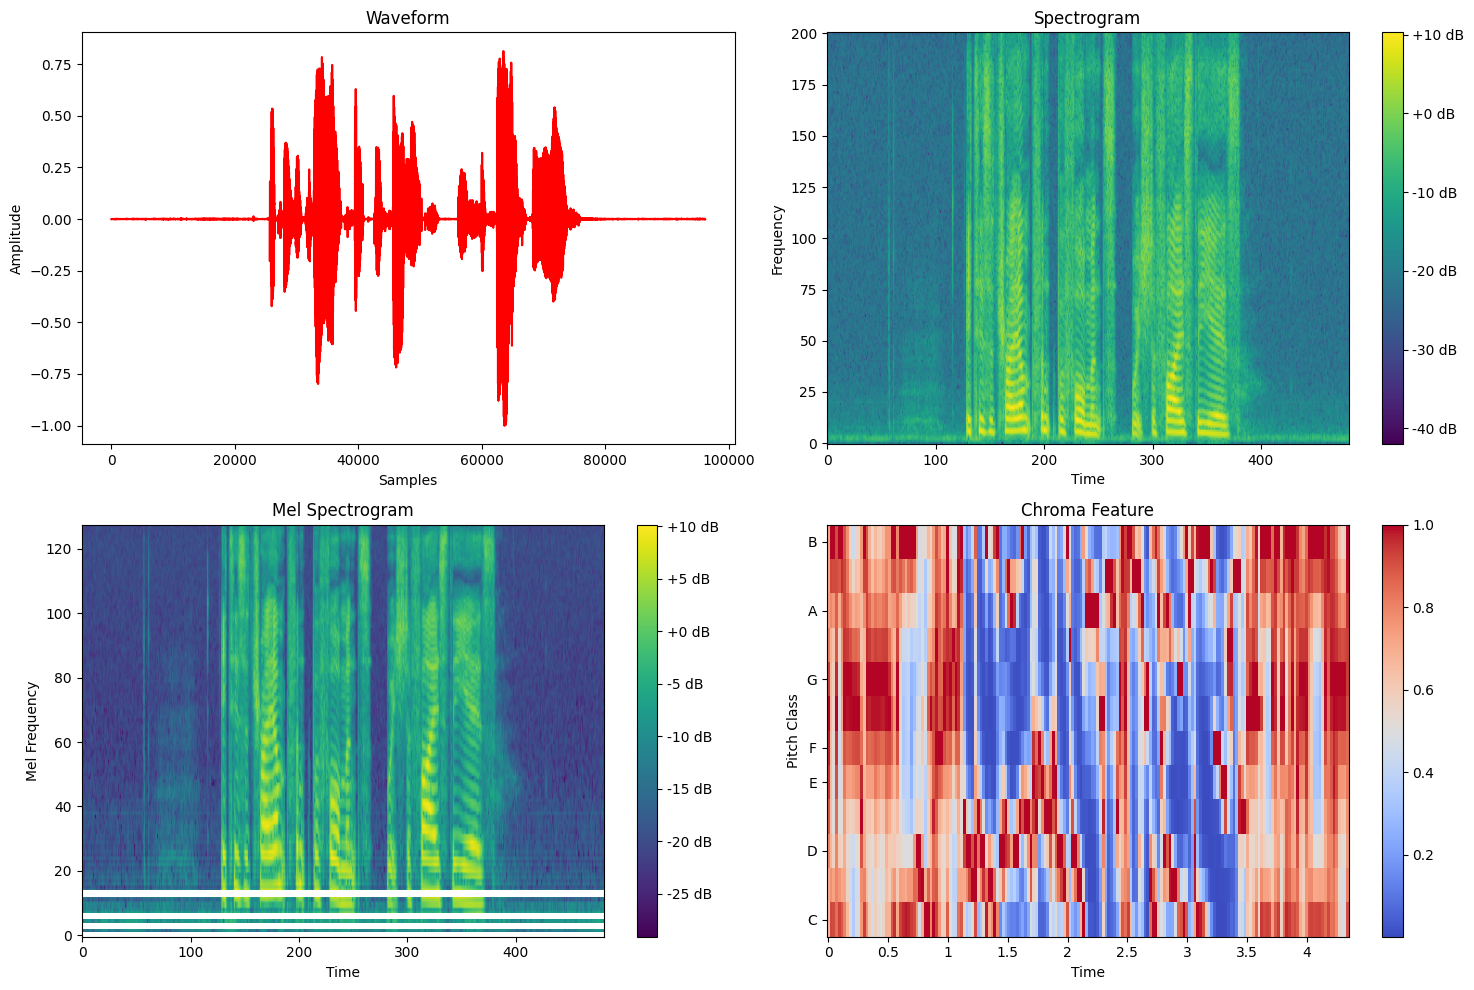

Playing Audio:


In [6]:
visualize_audio_features(audio_file="/content/selected_train_audio/bonafide/LA_T_1011221.flac")

### Visualize Spoof Audio Sample

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


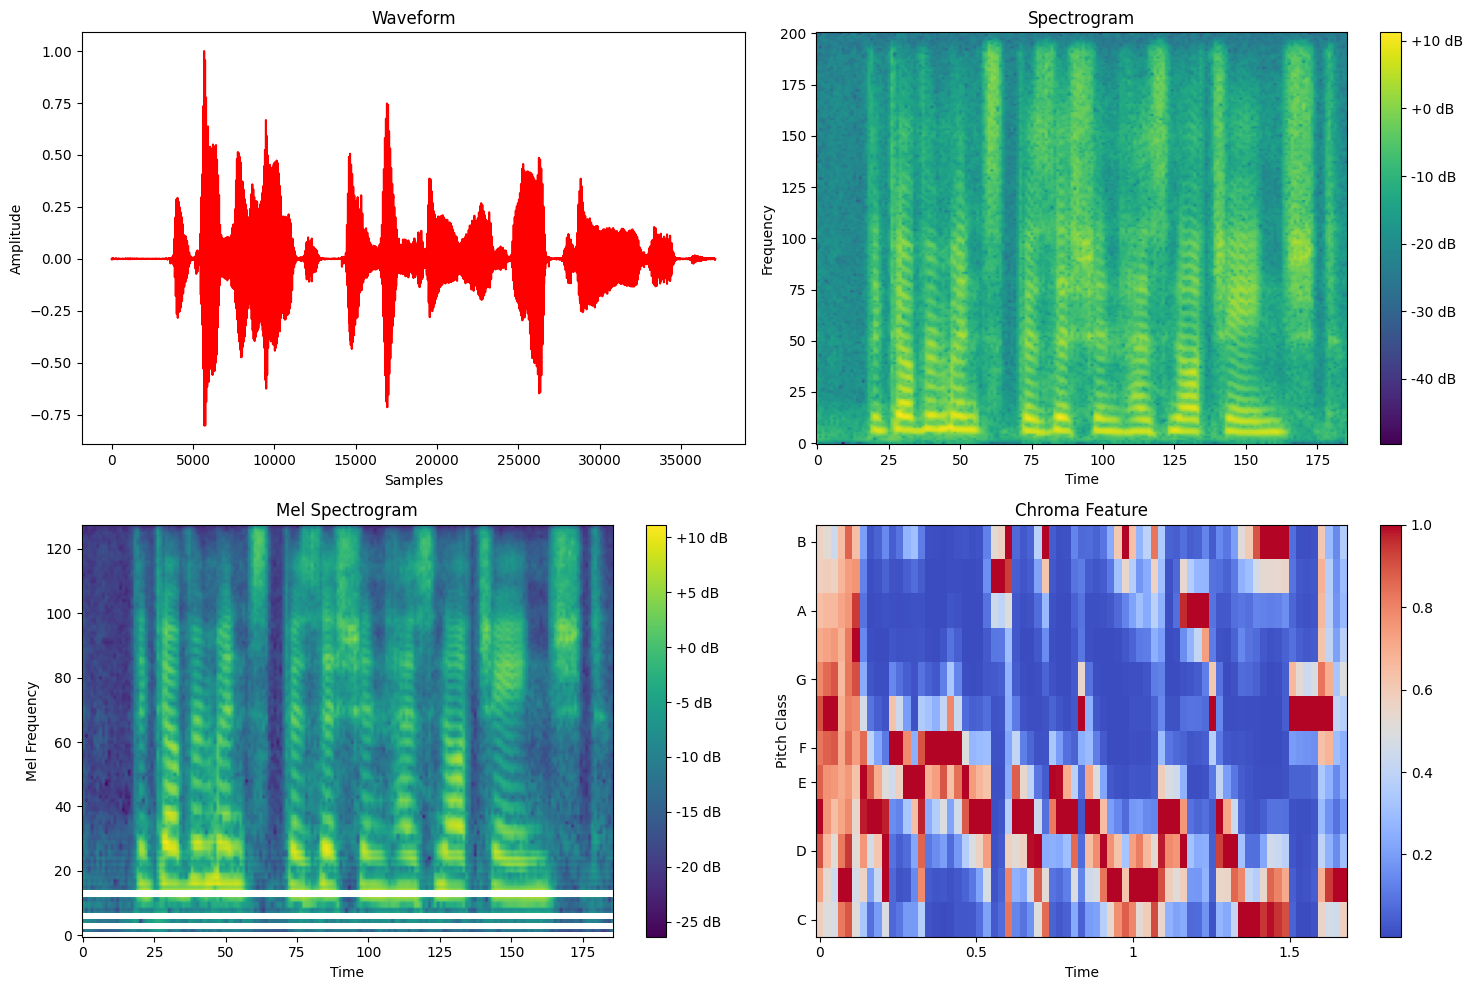

Playing Audio:


In [7]:
visualize_audio_features(audio_file="/content/selected_train_audio/spoof/LA_T_1001718.flac")

## Dataset Pipeline for Audio Dataset

In [8]:
# Dataset Class for Model Training
class ASVSpoof(Dataset):
    def __init__(self, base_dir, csv_file, target_length=64000):
        """
        Initializes the ASVSpoof dataset for WavLM.

        Args:
            base_dir (str): Base directory containing the 'bonafide' and 'spoof' subdirectories,
                            where audio files are organized by label.
            csv_file (str): Path to a CSV file with two columns, 'Filename' and 'Label', indicating
                            the filename of each audio file and its label ('bonafide' or 'spoof').
            target_length (int): Desired length (in samples) of each audio clip after padding or trimming.
                                 For a 16 kHz sampling rate, 64000 samples represent 4 seconds.
        """
        self.base_dir = base_dir
        self.target_length = target_length

        # Load the CSV file as a DataFrame and map labels to integer values
        self.data = pd.read_csv(csv_file)
        self.label_mapping = {"bonafide": 0, "spoof": 1}
        self.data['Label'] = self.data['Label'].map(self.label_mapping)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the filename and label at the given index
        file_name = self.data.loc[idx, 'Filename']
        label = self.data.loc[idx, 'Label']

        # Determine the subdirectory ('bonafide' or 'spoof') based on the label
        subdir = "bonafide" if label == 0 else "spoof"

        # Construct the full path to the audio file
        file_path = os.path.join(self.base_dir, subdir, f"{file_name}.flac")

        # Load the audio file and convert it to mono if it has multiple channels
        audio, sample_rate = torchaudio.load(file_path)
        if audio.shape[0] > 1:
            audio = audio.mean(dim=0, keepdim=True)  # Convert to mono by averaging channels

        # Trim or pad the audio to the target length
        audio = self.trim_or_pad_audio(audio.squeeze())

        # Return raw audio and label; processing will happen in collate_fn
        return {
            "audio": audio,
            "label": torch.tensor(label, dtype=torch.long)
        }

    def trim_or_pad_audio(self, audio):
        """
        Pads or trims the audio tensor to match the target length.

        Args:
            audio (torch.Tensor): 1D tensor of audio samples.

        Returns:
            torch.Tensor: Audio tensor with length equal to target_length.
        """
        if len(audio) > self.target_length:
            return audio[:self.target_length]
        elif len(audio) < self.target_length:
            padding = self.target_length - len(audio)
            return torch.nn.functional.pad(audio, (0, padding))
        return audio

In [9]:
# Initialize the Wav2Vec2FeatureExtractor for WavLM model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")

def collate_fn(batch):
    """
    Custom collate function to process batches of raw audio data using Wav2Vec2FeatureExtractor.

    Args:
        batch (list): A list of samples, where each sample is a dictionary containing:
                      - 'audio': raw audio tensor
                      - 'label': integer label for the audio

    Returns:
        dict: A dictionary containing:
              - 'input_values': Processed audio features ready for model input
              - 'attention_mask': Mask to handle padded values
              - 'labels': Tensor of labels for each sample in the batch
    """
    # Extract raw audio and labels from the batch
    audios = [item["audio"] for item in batch]  # List of raw audio tensors
    labels = torch.tensor([item["label"] for item in batch])  # Tensor of labels

    # Use the feature extractor to process the audio batch
    inputs = feature_extractor(
        audios,
        sampling_rate=16000,
        return_tensors="pt",
        padding="longest"  # Can be "max_length" if a specific length is required
    )

    # Return the processed inputs and labels in a dictionary format
    return {
        "input_values": inputs.input_values.squeeze(0),       # Mel-spectrogram feature sequences
        "attention_mask": inputs.attention_mask.squeeze(0),   # Attention mask to handle padding
        "labels": labels.squeeze(0)                           # Batch of labels
    }

def create_dataloader(base_dir, csv_file, batch_size=4, shuffle=True):
    """
    Creates an optimized DataLoader for the ASVSpoof dataset.

    Args:
        base_dir (str): Path to base directory containing audio files in 'bonafide' and 'spoof' subdirectories.
        csv_file (str): Path to CSV file with filenames and labels.
        batch_size (int, optional): Number of samples per batch. Default is 4.
        shuffle (bool, optional): Whether to shuffle the data. Default is True.

    Returns:
        DataLoader: Configured DataLoader for the ASVSpoof dataset.
    """
    # Initialize the dataset with specified base directory, CSV file, and target length
    dataset = ASVSpoof(base_dir, csv_file, target_length=64000)

    # Create and return the DataLoader with custom collate function
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn  # Use custom collate function to process raw audio
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

In [ ]:
# Configuration settings for the ASVSpoof project.


# Directory paths for training, validation, and test datasets

BASE_DIRS = {
    "train": "/content/selected_train_audio/",
    "val": "/content/selected_val_audio/",
    "test": "/content/selected_test_audio/"
}


CSV_FILES = {
    "train": "/content/train_balanced_dataframe.csv",
    "val": "/content/val_dataframe.csv",
    "test": "/content/test_dataframe.csv"
}

# Model configuration
BASE_MODEL = "microsoft/wavlm-base"  # Name of the base model to use (from Hugging Face Transformers)
NUM_LABELS = 1                       # Number of labels for classification (binary classification: real/fake)

# Training parameters
BATCH_SIZE = 40  # Number of samples per batch during training and evaluation

## Model Definition WavLM For Deepfake Detection

In [11]:
from transformers import WavLMModel
# Model definition for WavLM based deepfake audio detection
class WavLMClassifier(nn.Module):
    """
    A custom audio classifier using WavLM's encoder for binary classification.
    This model utilizes WavLM as a feature extractor and adds a simple linear layer as a classification head.
    """

    def __init__(self, model_name: str, num_labels: int):
        """
        Initializes the WavLMClassifier.

        Args:
            model_name (str): Name of the WavLM model from Hugging Face model hub.
            num_labels (int): Number of output labels for classification.
        """
        super(WavLMClassifier, self).__init__()

        # Load WavLM model without the classification head
        self.wavlm_model = WavLMModel.from_pretrained(model_name)

        # Optional: Freeze WavLM model parameters to prevent updates during training
        for param in self.wavlm_model.parameters():
            param.requires_grad = False

        # Get the hidden size of the WavLM encoder to define the classifier input size
        hidden_size = self.wavlm_model.config.hidden_size

        # Classification head: a linear layer mapping from hidden_size to num_labels
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_values):
        """
        Forward pass through the WavLMClassifier.

        Args:
            input_values (torch.Tensor): Preprocessed audio features tensor of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: Logits for each class (batch_size, num_labels).
        """
        # Pass inputs through WavLM encoder to get hidden states
        outputs = self.wavlm_model(input_values)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # Pool the hidden states across the sequence dimension (e.g., take the mean)
        pooled_output = last_hidden_state.mean(dim=1)  # Shape: (batch_size, hidden_size)

        # Pass pooled output through the classifier to get logits
        logits = self.classifier(pooled_output)

        return logits

    def predict(self, input_values: torch.Tensor) -> int:
        """
        Makes a binary prediction based on the preprocessed audio input.

        Args:
            input_values (torch.Tensor): Preprocessed audio features tensor.

        Returns:
            int: Predicted class (0 or 1).
        """
        # Perform a forward pass to get logits
        logits = self.forward(input_values)

        # Apply sigmoid and classify based on a threshold of 0.5
        predicted_class = (torch.sigmoid(logits) > 0.5).long().item()

        return predicted_class

In [20]:
# Define the model for training
model = WavLMClassifier(model_name=BASE_MODEL, num_labels=NUM_LABELS)

# Create DataLoaders for the training, validation, and test sets
train_loader = create_dataloader(BASE_DIRS["train"], CSV_FILES["train"], batch_size=BATCH_SIZE)
val_loader = create_dataloader(BASE_DIRS["val"], CSV_FILES["val"], batch_size=BATCH_SIZE)
test_loader = create_dataloader(BASE_DIRS["test"], CSV_FILES["test"], batch_size=BATCH_SIZE)

# Example: Accessing and printing shapes of a batch from train_loader
print("Train Loader Batch Shapes:")
for batch in train_loader:
    print("Input Values Shape:", batch["input_values"].shape)      # Shape of input features
    print("Attention Mask Shape:", batch["attention_mask"].shape)  # Shape of attention mask
    print("Labels Shape:", batch["labels"].shape)                  # Shape of labels
    break  # Exit after printing the shape of one batch

# Example: Accessing and printing shapes of a batch from val_loader
print("\nValidation Loader Batch Shapes:")
for batch in val_loader:
    print("Input Values Shape:", batch["input_values"].shape)      # Shape of input features
    print("Attention Mask Shape:", batch["attention_mask"].shape)  # Shape of attention mask
    print("Labels Shape:", batch["labels"].shape)                  # Shape of labels
    break  # Exit after printing the shape of one batch

# Example: Accessing and printing shapes of a batch from test_loader
print("\nTest Loader Batch Shapes:")
for batch in test_loader:
    print("Input Values Shape:", batch["input_values"].shape)      # Shape of input features
    print("Attention Mask Shape:", batch["attention_mask"].shape)  # Shape of attention mask
    print("Labels Shape:", batch["labels"].shape)                  # Shape of labels
    break  # Exit after printing the shape of one batch

Train Loader Batch Shapes:
Input Values Shape: torch.Size([40, 64000])
Attention Mask Shape: torch.Size([40])
Labels Shape: torch.Size([40])

Validation Loader Batch Shapes:
Input Values Shape: torch.Size([40, 64000])
Attention Mask Shape: torch.Size([40])
Labels Shape: torch.Size([40])

Test Loader Batch Shapes:
Input Values Shape: torch.Size([40, 64000])
Attention Mask Shape: torch.Size([40])
Labels Shape: torch.Size([40])


In [ ]:
# Calculating forward and backward pass memory
# Total memory used by model parameters (in bytes)
from torchinfo import summary

# Assuming `model` is your PyTorch model
batch_size = 10  # Or the batch size you'd like to simulate
input_shape = (batch_size, 64000)  # Replace `input_shape` with your model's input dimensions

# Print the model summary
summary(model, input_size=input_shape, col_names=["input_size", "output_size", "num_params", "params_percent"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Param %
WavLMClassifier                                         [10, 64000]               [10, 1]                   --                             --
├─WavLMModel: 1-1                                       [10, 64000]               [10, 199, 512]            768                         0.00%
│    └─WavLMFeatureEncoder: 2-1                         [10, 64000]               [10, 512, 199]            --                             --
│    │    └─ModuleList: 3-1                             --                        --                        (4,200,448)                 4.45%
│    └─WavLMFeatureProjection: 2-2                      [10, 199, 512]            [10, 199, 768]            --                             --
│    │    └─LayerNorm: 3-2                              [10, 199, 512]            [10, 199, 512]            (1,024)                     0.00%
│    │

## Train Loop for Training

In [ ]:
# Check if directory exists, if not create it
if  os.path.exists("./WavLM") == False:
    os.mkdir("./WavLM")

In [25]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb

# Configuration and constants
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
GAMMA = 0.9  # Decay factor for exponential LR scheduler
NUM_EPOCHS = 20
ACCUMULATION_STEPS = 4
CHECKPOINT_PATH = "./WavLM/WavLM_checkpoint.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Enable cuDNN for optimized computation on compatible architectures
torch.backends.cudnn.benchmark = True

# Initialize Weights and Biases (wandb) logging
wandb.init(project="audio-classification", name="WavLM Deepfake Detection")

# Move model to the appropriate device
model = model.to(DEVICE)

# Define optimizer, scheduler, and loss function
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss function

# Mixed precision scaler for efficient training on compatible hardware
scaler = torch.cuda.amp.GradScaler()

# Lists to keep track of training and validation losses over epochs
train_losses, val_losses = [], []

def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    """
    Loads model checkpoint if available, else initializes fresh training.

    Args:
        checkpoint_path (str): Path to the saved checkpoint.
        model (torch.nn.Module): Model to load the checkpoint into.
        optimizer (torch.optim.Optimizer): Optimizer to load state into.
        scheduler (torch.optim.lr_scheduler): Scheduler to load state into.

    Returns:
        tuple: starting epoch, best validation loss
    """
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resuming from epoch {start_epoch+1} with best validation loss {best_val_loss:.4f}")
        return start_epoch, best_val_loss
    else:
        print("No checkpoint found. Starting training from scratch.")
        return 0, float('inf')

# Load checkpoint if available
start_epoch, best_val_loss = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler)

No checkpoint found. Starting training from scratch.


<ipython-input-25-f950e4292a22>:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [27]:
# Training and Validation function
def train_and_validate(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, start_epoch=0, best_val_acc=0):
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        print("Model is running on:", next(model.parameters()).device)

        running_loss = 0.0
        correct = 0
        total = 0

        # Improve DataLoader efficiency
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

        optimizer.zero_grad()  # Reset gradients before each epoch
        for i, batch in enumerate(train_bar):
            inputs = batch["input_values"].to(DEVICE, non_blocking=True)
            labels = batch["labels"].to(DEVICE, non_blocking=True).float()  # Convert labels to float

            # Mixed precision training with autocast
            with torch.amp.autocast("cuda"):
                # Forward pass
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensuring outputs have shape [batch_size]
                loss = criterion(outputs, labels)
                loss = loss / ACCUMULATION_STEPS  # Scale the loss for accumulation

            # Backward pass
            scaler.scale(loss).backward()

            # Update weights and zero gradients after ACCUMULATION_STEPS iterations

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Track metrics efficiently with vectorized operations
            running_loss += loss.detach() * inputs.size(0) * ACCUMULATION_STEPS
            predicted = (outputs > 0).long()  # Use threshold of 0 for binary classification
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()

        # Calculate training loss and accuracy
        epoch_train_loss = running_loss.item() / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            for batch in val_bar:
                inputs = batch["input_values"].to(DEVICE, non_blocking=True)
                labels = batch["labels"].to(DEVICE, non_blocking=True).float()  # Convert labels to float

                # Mixed precision training with autocast
                with torch.amp.autocast("cuda"):
                    # Forward pass
                    outputs = model(inputs)
                    outputs = outputs.squeeze()  # Ensuring outputs have shape [batch_size]
                    loss = criterion(outputs, labels)

                # Track validation metrics efficiently
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0).long()  # Use threshold of 0 for binary classification
                val_total += labels.size(0)
                val_correct += (predicted == labels.long()).sum().item()

        # Calculate validation loss and accuracy
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        # Logging to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_train_loss,
            'train_accuracy': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_acc
        })

        # Save model if it has the best validation accuracy
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            model_save_path = f"./WavLM/WavLM_best_val_acc_{best_val_acc:.2f}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc
            }, model_save_path)
            print(f"New best model saved with validation accuracy {best_val_acc:.2f}% at epoch {epoch + 1}")

        # Step the scheduler
        scheduler.step()


# Run training and validation
train_and_validate(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, start_epoch=start_epoch, best_val_acc=0)

# End WandB session if using wandb
wandb.finish()

Model is running on: cuda:0


KeyboardInterrupt: 

We trained the model but device was in a hung state for long time, so had to terminate it manually 

## Evaluating the Model on Test Dataset

In [28]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# # Instantiate the WavLM model
model = WavLMClassifier(model_name=BASE_MODEL, num_labels=NUM_LABELS)  # Adjust model_name and num_labels as needed
model = model.to(device)

# Load the checkpoint (replace with the actual checkpoint path if needed)
checkpoint_path = "/content/WavLM/WavLM_best_val_acc_91.10.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])


def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing", leave=False)
        for batch in test_bar:
            # Extract input features and labels from the batch dictionary
            input_features = batch["input_values"].to(device)  # Corrected to match your dictionary key
            labels = batch["labels"]

            # Forward pass
            logits = model(input_features).squeeze()  # Remove extra dimensions if present

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)

            # Classify based on a 0.5 threshold
            predicted = (probs > 0.5).long()

            # Store predictions and labels for metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print and log the metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Optional: return metrics for further analysis
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Run the evaluation
test_metrics = evaluate_model(model, test_loader)

<ipython-input-28-4bb30871c50a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
                             

Test Accuracy: 0.9065
Precision: 0.9433
Recall: 0.8650
F1 Score: 0.9025
